In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel

fmri_dataset = 'data/dataset/dataset_all_subjects_LEiDA.hdf5'

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

# Mixture modelling - Synthectic data

### Generetate Synthetic 3D dataset

In [3]:
sig1 = torch.diag(torch.tensor([1, 1e-3, 1e-3]))
sig2 = torch.eye(3) + 0.9 * (torch.ones(3) - torch.eye(3))
sig3 = torch.diag(torch.tensor([1e-3, 1, 1])) \
       + 0.9 * torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

SIGMAs = torch.stack([sig1, sig2, sig3], dim=0)
#print(SIGMAs, '\n-----------')

PIs = [0.6, 0.2, 0.2]

X, cluster_id = syntheticMixture3D(pi=PIs, Sigmas=SIGMAs, num_points=3000, as_array=False)

Simulate 3000 point from 3 of clusters


### Train on synthecic data

<IPython.core.display.Javascript object>


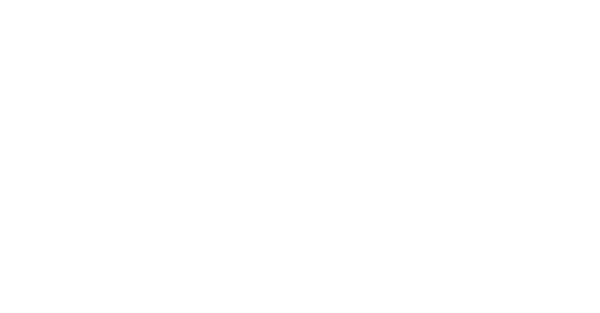

pi
tensor([0.2548, 0.4518, 0.2934])
------------------------------
mix_comp_0
{'mu': tensor([0.4323, 0.6788, 0.5936]), 'kappa': tensor([0.5222])}
------------------------------
mix_comp_1
{'mu': tensor([0.8803, 0.4454, 0.1632]), 'kappa': tensor([0.8993])}
------------------------------
mix_comp_2
{'mu': tensor([0.4913, 0.5728, 0.6561]), 'kappa': tensor([0.3075])}
------------------------------


100%|█████████████████████████████████████| 600/600 [00:01<00:00, 304.33it/s]

pi
tensor([0.3623, 0.6366, 0.0012])
------------------------------
mix_comp_0
{'mu': tensor([0.5229, 0.5878, 0.6173]), 'kappa': tensor([2.5979])}
------------------------------
mix_comp_1
{'mu': tensor([ 1.0000e+00, -2.0657e-04,  6.9069e-04]), 'kappa': tensor([76.1588])}
------------------------------
mix_comp_2
{'mu': tensor([0.0032, 0.7201, 0.6939]), 'kappa': tensor([43.4121])}
------------------------------


<IPython.core.display.Javascript object>


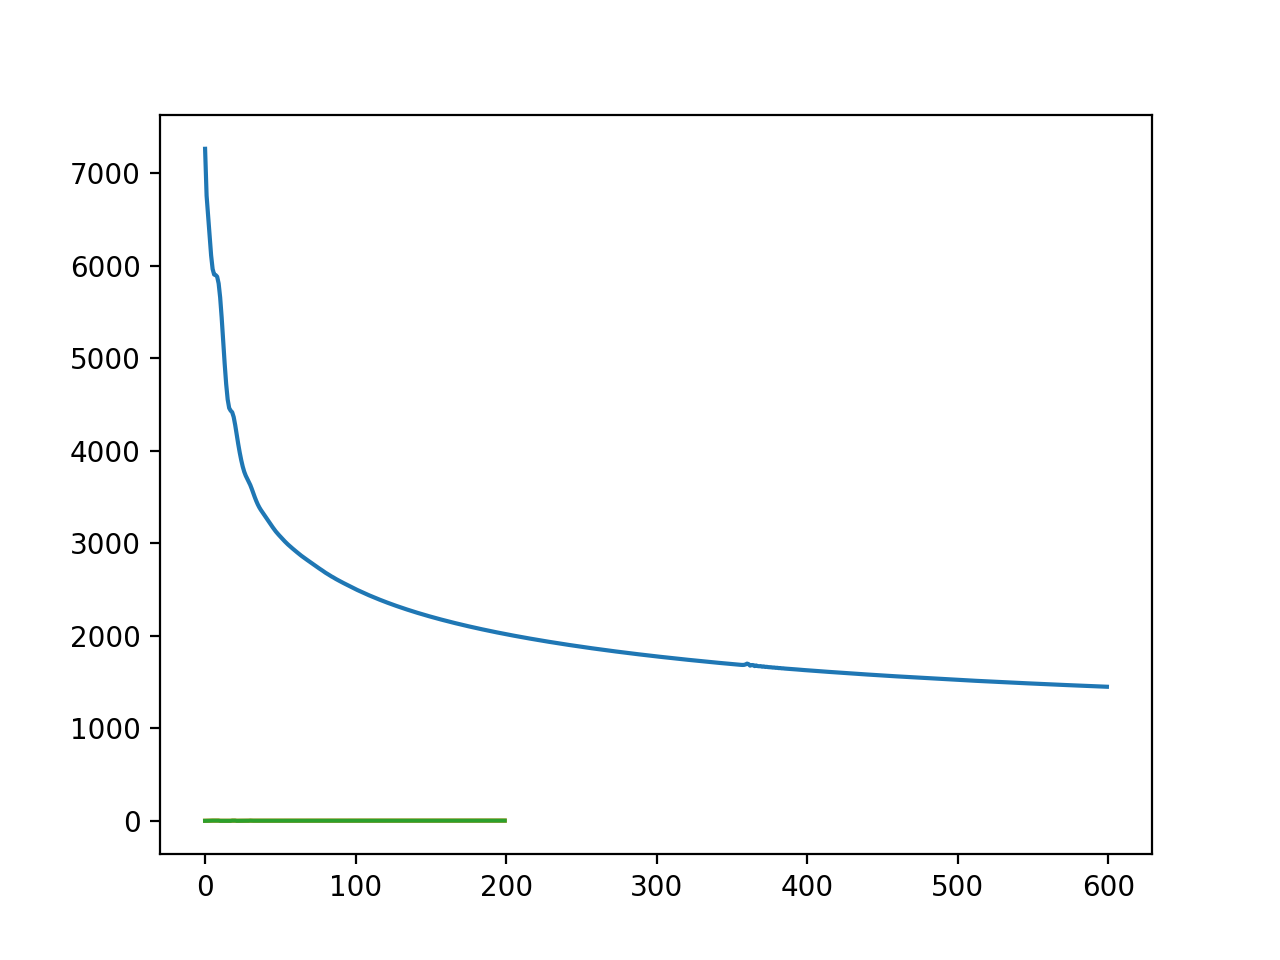

Min LL: 1448.7593994140625


In [116]:
plt.clf()
%matplotlib notebook
model_dist = Watson
model = TorchMixtureModel(model_dist, K=3, dist_dim=3)

_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.4)

epoch_likelihood = train_mixture(model, data=X, optimizer=Adam_optimizer, num_epoch=600)

_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()
print(f'Min LL: {epoch_likelihood[-1]}')

### Fitting paramerter results

In [85]:
param = get_param(model)

pi
tensor([0.4505, 0.0006, 0.5490])
------------------------------
mix_comp_0
{'mu': tensor([0.5963, 0.5594, 0.5757]), 'kappa': tensor([2.4793])}
------------------------------
mix_comp_1
{'mu': tensor([0.0061, 0.6972, 0.7169]), 'kappa': tensor([47.6668])}
------------------------------
mix_comp_2
{'mu': tensor([ 1.0000e+00, -5.4645e-04, -1.6002e-03]), 'kappa': tensor([233.4122])}
------------------------------


In [86]:
## Synthectic as np array
synX, syn_cluster_id = np.array(X), np.array(cluster_id)

## Plot of Synthetic | Learned Mixture Clusters from Parameters | Watson $\mu$ directions

<IPython.core.display.Javascript object>


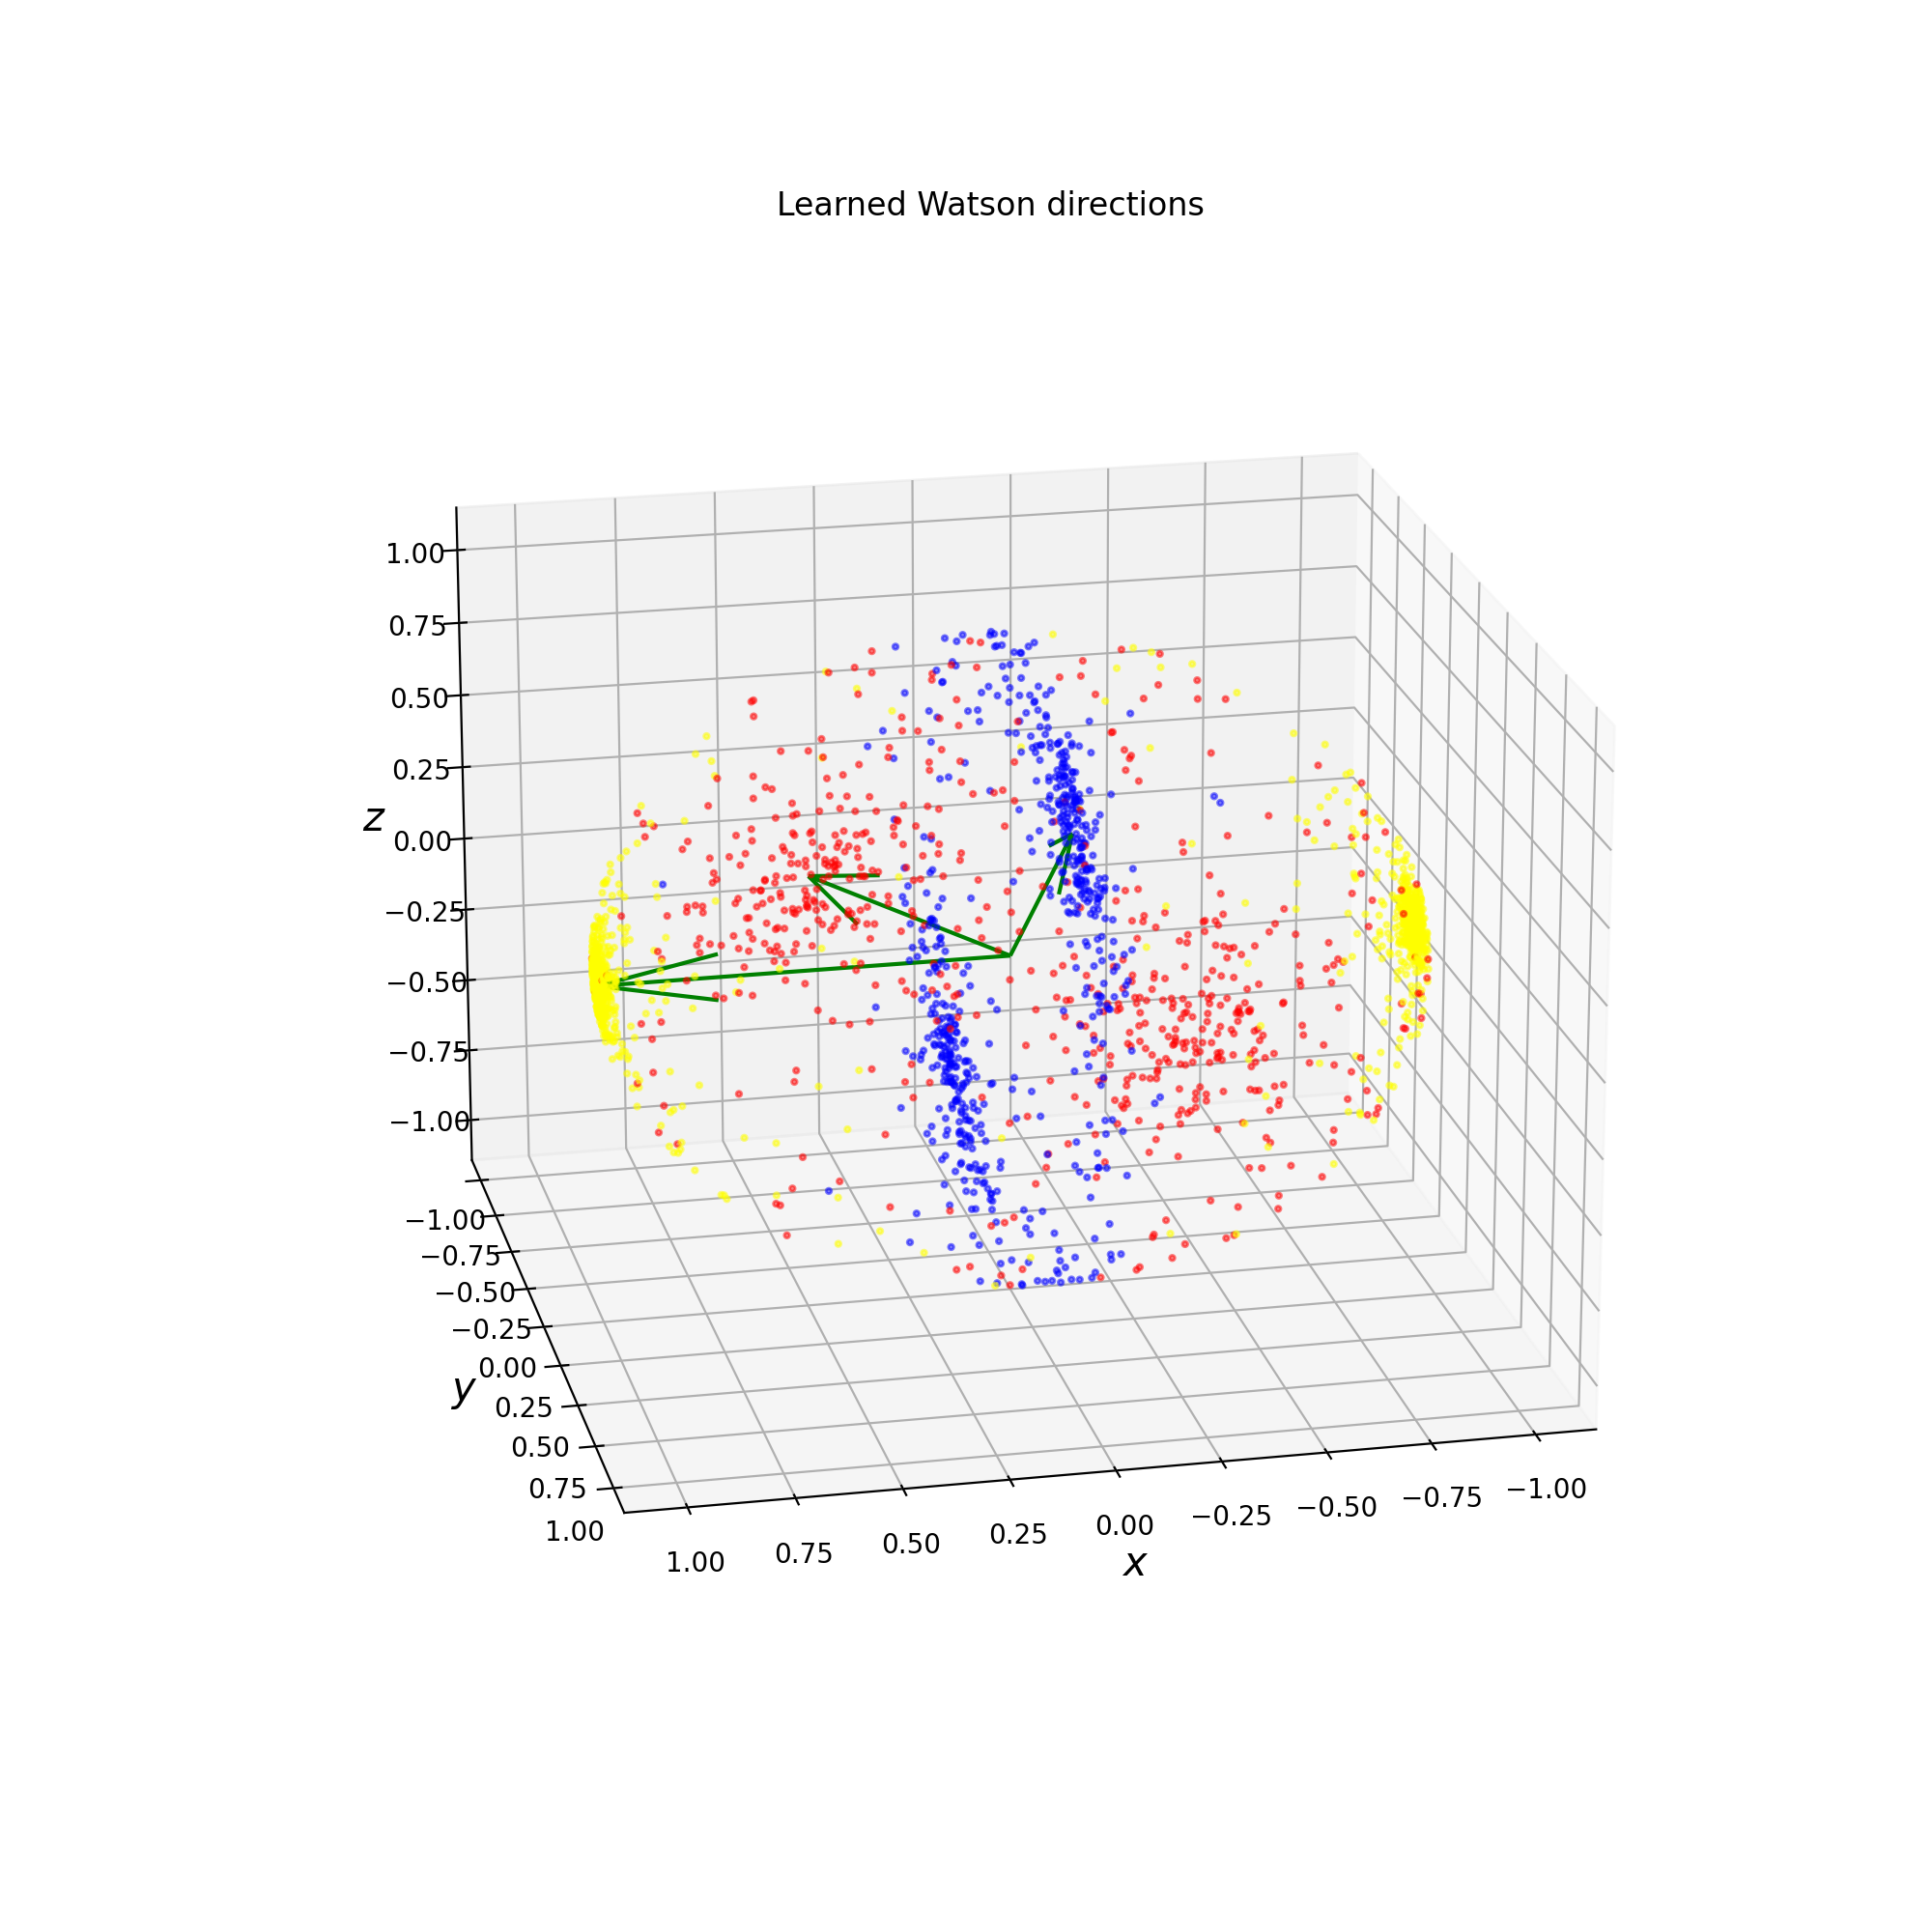

In [91]:
if model_dist == ACG:
    learned_sigma = torch.stack([param[f'mix_comp_{idx}'] for idx in range(model.K)])
    learned_pi = param['pi']
    LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

    # Synthetic
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    label_color = [id_2_color[id] for id in syn_cluster_id]
    ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Synthetic')
    #Background
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)

    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)

    x = .95 * np.outer(np.cos(u), np.sin(v))
    y = .95 * np.outer(np.sin(u), np.sin(v))
    z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
    ax.view_init(30, 135)

    # Learned
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    label_color = [id_2_color[id] for id in Learn_cluster_id]
    ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Generated - Learned parameters')
    ax.view_init(30, 135)
    plt.show()


elif model_dist == Watson:
    Watson_comps = [param[f'mix_comp_{idx}'] for idx in range(model.K)]
    learned_pi = param['pi']
    
    
    fig = plt.figure(figsize=(10,10))
    id_2_color = {0: 'yellow', 1: 'red', 2: 'blue'}

#     # Synthetic
#     ax = fig.add_subplot(1, 2, 1, projection='3d')
#     label_color = [id_2_color[id] for id in syn_cluster_id]
#     ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
#     ax.set_xlabel('$x$', fontsize=15)
#     ax.set_ylabel('$y$', fontsize=15)
#     ax.set_zlabel('$z$', fontsize=15)
#     ax.set_title('Synthetic')
    #Background
#     ax.xaxis.pane.fill = False
#     ax.yaxis.pane.fill = False
#     ax.zaxis.pane.fill = False
#     ax.xaxis.pane.set_edgecolor('w')
#     ax.yaxis.pane.set_edgecolor('w')
#     ax.zaxis.pane.set_edgecolor('w')
#     ax.grid(False)

#     u = np.linspace(0, 2 * np.pi, 20)
#     v = np.linspace(0, np.pi, 20)

#     x = .95 * np.outer(np.cos(u), np.sin(v))
#     y = .95 * np.outer(np.sin(u), np.sin(v))
#     z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
#     ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
#     ax.view_init(30, 135)

    # Synthetic with Mean direction from watson
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    label_color = [id_2_color[id] for id in syn_cluster_id]
    ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Learned Watson directions')
    # Watson Mu
    for w_param in Watson_comps:
        mu_vec = np.array(w_param['mu'])
        kappa_p = w_param['kappa']
        ax.quiver(0, 0, 0, *mu_vec, color = 'g')
    ax.view_init(30, 135)
    plt.show()
    

# Hidden Markov Model - Synthetic data

In [21]:
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from models.HMM.HMM_torch import HiddenMarkovModel as HMM
from data.synthetic_generator import syntheticHMM
from utils.training import train_hmm

Pi: [0.6, 0.2, 0.2]
Simulate sequence of length 100 from 3 hidden states


<IPython.core.display.Javascript object>


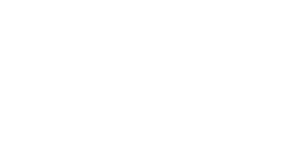

<IPython.core.display.Javascript object>


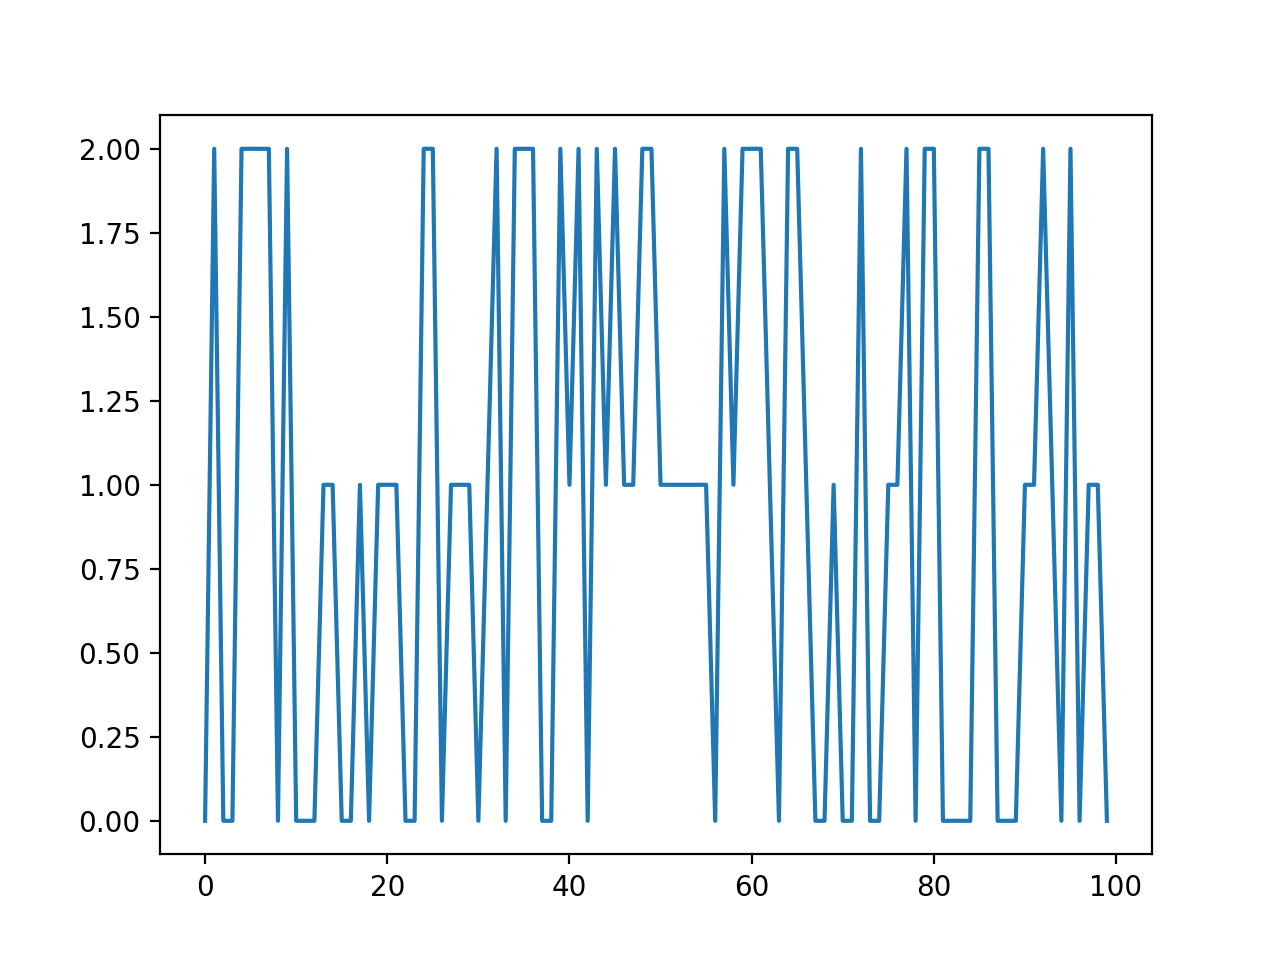

In [5]:
TRANSITION = torch.tensor([[0.4, 0.4, 0.2],
                          [0.2, 0.6, 0.2],
                          [0.4, 0.3, 0.3]])

print(f'Pi: {PIs}')
X_emission, Z_seq = syntheticHMM(pi=PIs, Sigmas=SIGMAs, transition_matrix=TRANSITION, seq_len=100)
plt.clf()
%matplotlib notebook
plt.plot(Z_seq)
plt.show()

### Training HMM on synthetic data

In [6]:
model_dist = ACG
model = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.1)
model.viterbi(X_emission.unsqueeze(dim=0))[0]

priors
tensor([0.3475, 0.3399, 0.3126])
------------------------------
Transition_matrix
tensor([[0.3439, 0.3323, 0.3238],
        [0.3023, 0.3583, 0.3395],
        [0.2979, 0.3772, 0.3249]])
------------------------------
emission_model_0
tensor([[0.2538, 0.2326, 0.9284],
        [0.2326, 0.9370, 0.2327],
        [0.9284, 0.2327, 3.9474]])
------------------------------
emission_model_1
tensor([[0.6017, 0.0591, 0.5937],
        [0.0591, 0.4087, 0.1106],
        [0.5937, 0.1106, 1.2716]])
------------------------------
emission_model_2
tensor([[ 0.9559,  0.9293, -0.4193],
        [ 0.9293,  1.5215, -0.1255],
        [-0.4193, -0.1255,  1.0750]])
------------------------------


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]])

100%|██████████████████████████████████████| 200/200 [00:36<00:00,  5.55it/s]

priors
tensor([9.9839e-01, 8.2167e-04, 7.8426e-04])
------------------------------
Transition_matrix
tensor([[0.5448, 0.2235, 0.2317],
        [0.1999, 0.4322, 0.3679],
        [0.4088, 0.3072, 0.2840]])
------------------------------
emission_model_0
tensor([[ 3.1134e-03,  1.6677e-03, -1.1719e-03],
        [ 1.6677e-03,  1.3259e+00,  2.2111e+00],
        [-1.1719e-03,  2.2111e+00,  7.0440e+00]])
------------------------------
emission_model_1
tensor([[ 8.8206,  0.6174, -4.0067],
        [ 0.6174,  0.0728, -0.2754],
        [-4.0067, -0.2754,  1.8400]])
------------------------------
emission_model_2
tensor([[0.2689, 0.1493, 0.7732],
        [0.1493, 0.3654, 1.3119],
        [0.7732, 1.3119, 7.6504]])
------------------------------


<IPython.core.display.Javascript object>


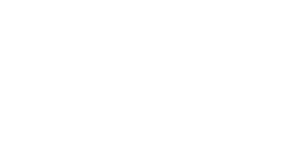

<IPython.core.display.Javascript object>


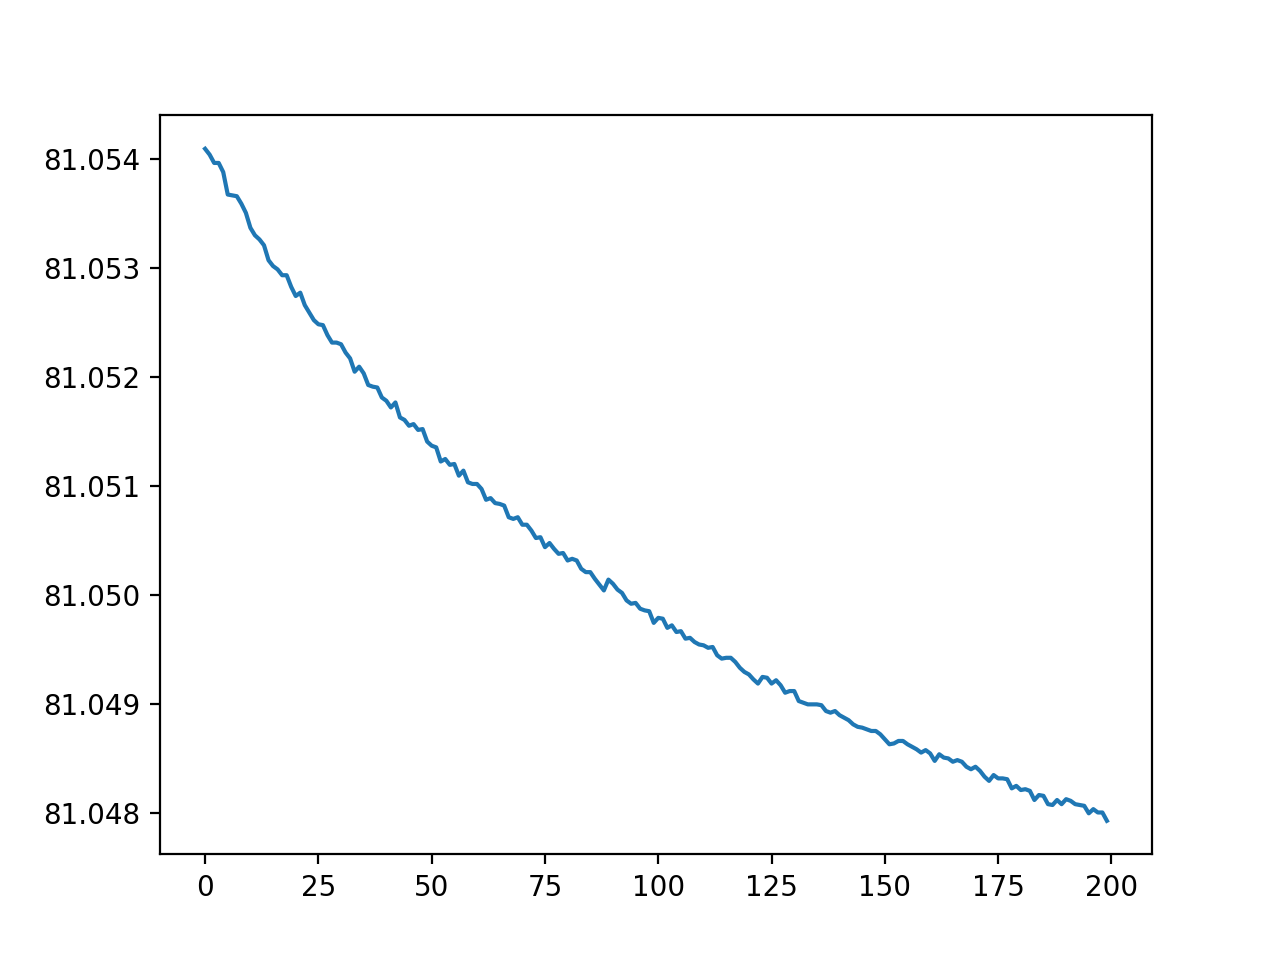

Min LL: 81.04792785644531
priors
tensor([9.9839e-01, 8.2167e-04, 7.8426e-04])
------------------------------
Transition_matrix
tensor([[0.5448, 0.2235, 0.2317],
        [0.1999, 0.4322, 0.3679],
        [0.4088, 0.3072, 0.2840]])
------------------------------
emission_model_0
tensor([[ 3.1134e-03,  1.6677e-03, -1.1719e-03],
        [ 1.6677e-03,  1.3259e+00,  2.2111e+00],
        [-1.1719e-03,  2.2111e+00,  7.0440e+00]])
------------------------------
emission_model_1
tensor([[ 8.8206,  0.6174, -4.0067],
        [ 0.6174,  0.0728, -0.2754],
        [-4.0067, -0.2754,  1.8400]])
------------------------------
emission_model_2
tensor([[0.2689, 0.1493, 0.7732],
        [0.1493, 0.3654, 1.3119],
        [0.7732, 1.3119, 7.6504]])
------------------------------


In [323]:
# add batch dim for HMM to X

epoch_likelihood = train_hmm(model, data=X_emission.unsqueeze(dim=0), optimizer=Adam_optimizer, num_epoch=200)

_ = get_param(model)

plt.clf()
%matplotlib notebook
plt.plot(epoch_likelihood)
plt.show()
print(f'Min LL: {epoch_likelihood[-1]}')
_ = get_param(model)

In [20]:
torch.rand(10,3)[0]

tensor([0.2870, 0.0361, 0.2495])

In [24]:
model.emission_models_forward(torch.rand(1,10,3)[:,0]).data.T

tensor([[-7.2026,  0.2605, -1.6543]])

In [330]:
seq, seq_prob = model.viterbi(X_emission.unsqueeze(dim=0))
seq

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]])

In [ ]:
def viterbi(
            self,
            obs_seq: Union[str, list, np.ndarray],
            obs: Optional[Union[list, np.ndarray]] = None,
            states: Optional[Union[list, np.ndarray]] = None,
            tp: Optional[np.ndarray] = None,
            ep: Optional[np.ndarray] = None,
            pi: Optional[Union[list, np.ndarray]] = None
            ) -> Tuple[np.ndarray, np.ndarray]:
        '''Viterbi algorithm.
        Parameters
        ----------
        obs_seq : Union[str, list, np.ndarray]
            Sequence of observations.
            
        obs : Optional[Union[list, np.ndarray]]
            Observations space (of size N).
            
        states : Optional[Union[list, np.ndarray]]
            List of states (of size K).
        tp : Optional[numpy.ndarray]
            Transition matrix (of size K × K) which stores transition
            probability of transiting from state i (row) to state j (col).
        ep : Optional[numpy.ndarray]
            Emission matrix (of size K × N) which stores probability of
            seeing observation j (col) from state i (row). N is the length of
            observation space, O = [o_1, o_2, ..., o_N].
        pi : Optional[Union[list, np.ndarray]]
            Initial probabilities array (of size K).
        Returns
        -------
        x : numpy.ndarray
            Sequence of states.
        z : numpy.ndarray
            Sequence of state indices.
        '''

        T = seq_max
        K = 

        def s(i):
            return np.argwhere(obs == obs_seq[i]).flatten().item()

        t1 = np.zeros((K, T))
        t2 = np.zeros((K, T))

        t1[:, 0] = pi * ep[:, s(0)]
        t1[:, 0] /= t1[:, 0].sum()
        t2[:, 0] = 0

        for i in range(1, T):
            t1[:, i] = np.max(t1[:, i-1] * tp * ep[:, s(i)], axis=1)
            t2[:, i] = np.argmax(t1[:, i-1] * tp * ep[:, s(i)], axis=1)
            t1[:, i] /= t1[:, i].sum()

        z = np.argmax(t1, axis=0)
        x = states[z]

        for i in reversed(range(1, T)):
            z[i-1] = t2[z[i], i]
            x[i-1] = states[z[i-1]]

        return x, z